In [1]:
import pandas as pd
import numpy as np
import nltk.corpus
from nltk import SnowballStemmer
from nltk.tokenize import word_tokenize

import pickle 

import nltk
import string

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import cluster
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances
from sklearn.manifold import TSNE

import matplotlib
import matplotlib.pyplot  as plt
import matplotlib.cm      as cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

import seaborn as sns
from sklearn.metrics import silhouette_samples, silhouette_score
from wordcloud import WordCloud

from unidecode import unidecode

import os, sys, re

In [2]:
data = pd.read_csv('data/harvard_general.csv', encoding='utf-8')
data.columns = map(str.lower, data.columns)
data_eng = data[data['lang'] == "en"]
data_eng['lang']

2       en
3       en
5       en
6       en
7       en
        ..
9972    en
9973    en
9977    en
9978    en
9979    en
Name: lang, Length: 7583, dtype: object

In [3]:
tweets = data_eng['text'].tolist()
tweets[0:10]

['@magninano China with the aid of RNA vaccine producers, Harvard, Fauci, Collins, NIH, and quite a few others.',
 "@Truth_Abides There's a lot of dots to connect, but the story is there and it predates the release of covid-19. Its is something I have tried to convey since March, but has fallen on deaf ears. Another string of articles. https://t.co/tVpqQjLSlD",
 '@mattdeter @cletusyeetus1 @CowgirlWarrior @IvyShoots @murmalerm @bobx_akins Harvard didn’t write that nonsense, rape apologist',
 '@mattdeter @CowgirlWarrior @cletusyeetus1 @IvyShoots @murmalerm @bobx_akins Reardon didn’t graduate from Harvard lmfaoooo',
 'Yes! @NicoleFleetwoo2 Nicole Fleetwood’s\xa0Marking Time: Art in the Age of Mass Incarceration\xa0(Harvard University Press, 2020) https://t.co/Reae0aQ8AL',
 'Woke up at 3 a.m. this morning to join Harvard Graduate School of Education webinar. https://t.co/8QJ9oiXhYP',
 '“If the identity and collective strength and resilience of students of color and their historical traumas

In [4]:
## clean text
def removeWords(listOfTokens, listOfWords):
    return [token for token in listOfTokens if token not in listOfWords]
def applyStemming(listOfTokens, stemmer):
    return [stemmer.stem(token) for token in listOfTokens]
def twoLetters(listOfTokens):
    twoLetterWord = []
    for token in listOfTokens:
        if len(token) <= 2 or len(token) >= 21:
            twoLetterWord.append(token)
    return twoLetterWord

In [5]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def processTweets(tweets, language):
    stopwords = nltk.corpus.stopwords.words(language)
    gist_file = open("data/more_stopwords", "r")

    try:
        content = gist_file.read()
        otherwords = content.split(",")
    finally:
        gist_file.close()

    param_stemmer = SnowballStemmer(language)
    otherwords = applyStemming(otherwords, param_stemmer)
    for i in range(len(tweets)):
        tweets[i] = tweets[i].replace(u'\ufffd', '8')
        tweets[i] = tweets[i].rstrip('\n')
        tweets[i] = tweets[i].casefold()

        tweets[i] = re.sub(r'http\S+', '', tweets[i])   
        tweets[i] = re.sub(r'www\S+', '', tweets[i])  
        tweets[i] = re.sub("\S*\d\S*", " ", tweets[i])
        tweets[i] = re.sub("\S*@\S*\s?"," ", tweets[i])
        tweets[i] = re.sub("(?!')[\W_]", ' ', tweets[i])
        tweets[i] = decontracted(tweets[i])
        listOfTokens = word_tokenize(tweets[i])
        tweets[i] = " ".join(listOfTokens)

        tweets[i] = tweets[i].replace("harvard university", "")
        tweets[i] = tweets[i].replace("harvard business school", "hbs business")
        tweets[i] = tweets[i].replace("harvard college", "hcollege")
        tweets[i] = tweets[i].replace("harvard division continuing education", "hdce")
        tweets[i] = tweets[i].replace("harvard school dental medicine", "hsdm")
        tweets[i] = tweets[i].replace("harvard faculty arts sciences", "hfas")
        tweets[i] = tweets[i].replace("harvard graduate school education", "hgse education")
        tweets[i] = tweets[i].replace("harvard graduate school arts sciences", "hgsas")
        tweets[i] = tweets[i].replace("harvard kennedy school", "hks")
        tweets[i] = tweets[i].replace("harvard law school", "hls law")
        tweets[i] = tweets[i].replace("harvard medical school", "hms medical")
        tweets[i] = tweets[i].replace("school public health", "public health")
        tweets[i] = tweets[i].replace("harvard graduate school", "hgsas")

        tweets[i] = tweets[i].replace("harvard", "")

        listOfTokens = word_tokenize(tweets[i])
        twoLetterWord = twoLetters(listOfTokens)

        listOfTokens = removeWords(listOfTokens, stopwords)
        listOfTokens = removeWords(listOfTokens, twoLetterWord)
        listOfTokens = removeWords(listOfTokens, otherwords)

        listOfTokens = applyStemming(listOfTokens, param_stemmer)
        listOfTokens = removeWords(listOfTokens, otherwords)


        tweets[i] = " ".join(listOfTokens)
        tweets[i] = unidecode(tweets[i])
    return tweets


In [6]:
twclean = tweets.copy()
twclean = processTweets(twclean, 'english')
print(len(twclean))
twclean[0:10]

7583


['china aid rna vaccin produc fauci collin nih',
 'lot dot connect stori predat releas convey march fallen deaf ear string articl',
 'write nonsens rape apologist',
 'reardon graduat lmfaoooo',
 'nicol fleetwood mark time art age mass incarcer press',
 'woke morn join hgsas educ webinar',
 'ident collect strength resili student color histor trauma acknowledg lack inclus pose threat mental health school public health',
 'grant point lost complet connect imagin leavimg total idiot theae dude',
 'posit news travel industri',
 'turn kfan morn hear birk talk pray trump bronz age myth nonsens unreal peopl talk realiti']

In [69]:
cleaned_data = {'tweets': tweets, 'cleaned_tweets': twclean}
cleaned_df = pd.DataFrame(cleaned_data)
cleaned_df.to_csv(path_or_buf="data/cleaned_data.csv", index=False)

In [7]:
vectorizer = TfidfVectorizer(stop_words = 'english', max_features = 5000)
X = vectorizer.fit_transform(twclean)
X_norm = normalize(X)

tf_idf = pd.DataFrame(data = X_norm.toarray(), columns=vectorizer.get_feature_names())

final_df = tf_idf

final_df.T

0     1     2     3     4     5     6     7     8     9     ...  \
aamc         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
aapplic      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
aaron        0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
abandon      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
abbott       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
...          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
ziblatt      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
zoetrop      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
zoom         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
zuck         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
zuckerberg   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   

            7573  7574  7575  7576  7577  7578  7579  7580  7581  7582  
aamc         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
aapplic      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
aaron        0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
abandon      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
abbott       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
...          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  
ziblatt      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
zoetrop      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
zoom         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
zuck         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
zuckerberg   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5000 rows x 7583 columns]

In [8]:
def run_KMeans(max_k, data):
    max_k += 1
    kmeans_results = dict()
    for k in range(2 , max_k):
        kmeans = cluster.KMeans(n_clusters = k
                               , init = 'k-means++'
                               , n_init = 10
                               , tol = 0.0001
                               , n_jobs = -1
                               , random_state = 1
                               , algorithm = 'auto')

        kmeans_results.update( {k : kmeans.fit(data)} )
        
    return kmeans_results

In [13]:
font = {'size': 20, 'family': 'Helvetica'}

matplotlib.rc('font', **font)

# colors
monochrome_colors = ['#251616', '#760000', '#C63F3F', '#E28073', '#F1D3CF']
primary_colors = ['#F4B436', '#83BFCC', '#C63F3F'] #'#E2DDDB',  '#455574', 

m = ListedColormap(primary_colors)
m2 = ListedColormap(['#F4B436', '#83BFCC', '#C63F3F', '#E2DDDB',  '#455574'])
m3 = ListedColormap(['#83BFCC', '#C63F3F'])
m4 = ListedColormap(['#83BFCC'])

In [10]:
sklearn_pca = PCA(n_components = 100, svd_solver = 'full')
Y_sklearn = sklearn_pca.fit_transform(final_df)

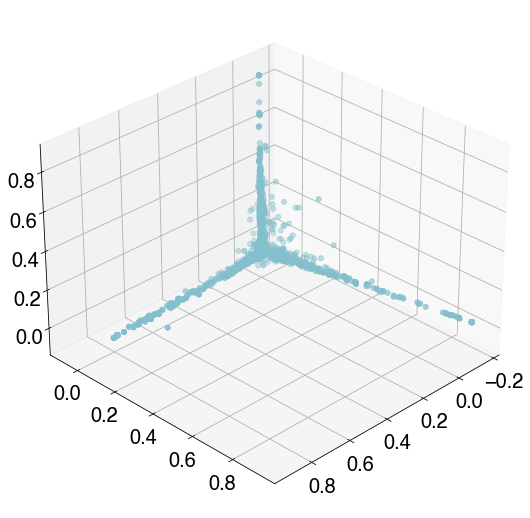

[0.01247711 0.02273832 0.0291868  0.03384621 0.03839919 0.04282815
 0.04713414 0.05135538 0.05547019 0.05957151 0.0634068  0.06706765
 0.07061289 0.07412414 0.07749586 0.08084292 0.08401846 0.08700098
 0.08987199 0.09265948 0.09539637 0.0980824  0.10072483 0.10335432
 0.10592595 0.1083555  0.11076673 0.1131448  0.11551019 0.11786041
 0.12016746 0.1224672  0.12473476 0.12699125 0.12919366 0.13136508
 0.13349139 0.13559338 0.13767247 0.13974204 0.1417952  0.14379643
 0.14576269 0.14772102 0.14965526 0.15157747 0.15347255 0.15535484
 0.15722681 0.15908196 0.16091763 0.16273705 0.16453302 0.16632007
 0.16809691 0.16985817 0.17159887 0.17332273 0.17503483 0.17673204
 0.17841781 0.18009205 0.18175308 0.18339945 0.18503111 0.18665045
 0.18826241 0.18985142 0.19143082 0.19300691 0.19455374 0.19609763
 0.19762909 0.19915079 0.20066251 0.20216159 0.20364246 0.20511101
 0.20657531 0.20803189 0.20947637 0.21091755 0.21234285 0.21376048
 0.21516285 0.21656393 0.21795272 0.21933393 0.22070581 0.2220

In [14]:
fig = plt.figure(figsize=(9, 7))
ax = Axes3D(fig)
#kmeans.fit(Y_sklearn)
# predicted_values = kmeans_results_2.get(3).predict(Y_sklearn)
ax.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], Y_sklearn[:, 2], c=[1]*len(Y_sklearn[:,0]), s=25, cmap=m4)
ax.view_init(elev=30., azim=45)

plt.savefig('img-final/pca-clustering.png')
plt.show()

print(sklearn_pca.explained_variance_ratio_.cumsum())

In [15]:
k = 40
kmeans_results = run_KMeans(k, pd.DataFrame(Y_sklearn))

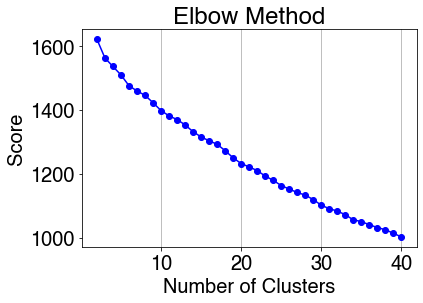

In [16]:
score = [kmeans_results.get(i).score(Y_sklearn) for i in range(2,k + 1)]
score = [i * -1 for i in score]
num_clusters = range(2, k + 1)

plt.plot(num_clusters, score, "o-b")
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Method')
plt.grid(axis="x")
plt.show()

In [ ]:
best_result = 18
kmeans = kmeans_results.get(best_result)

In [18]:
## reproducing results from original run:
with open("store_centroids-100comp-18clust.pckl", "rb") as f:
    orig_centroids = pickle.load(f)



array([[-2.20758114e-02, -1.07620669e-02, -1.08179460e-02, ...,
         1.49703089e-03, -2.59880116e-03,  4.97713777e-03],
       [-1.40761403e-02, -1.52001644e-02, -1.58672703e-02, ...,
         1.67281347e-04, -8.65257048e-06, -1.01618905e-04],
       [ 6.89132424e-01,  8.81132988e-02,  3.67375372e-02, ...,
        -1.19538824e-03, -1.53820271e-03, -2.14973793e-03],
       ...,
       [ 1.05601933e-01, -7.16975912e-03, -2.80039149e-02, ...,
         7.07492046e-04,  2.78124783e-03, -2.07268961e-03],
       [-6.62051716e-02,  2.72157899e-01,  8.94499224e-03, ...,
        -5.04339692e-04, -4.66563807e-03, -2.47641667e-03],
       [ 3.44778365e-03, -1.83833022e-02, -4.97199715e-02, ...,
         1.26318798e-02, -5.09407093e-03, -1.55973276e-03]])

In [22]:
orig_kmeans = cluster.KMeans(n_clusters = 18
                               , init = orig_centroids
                               , n_init = 10
                               , tol = 0.0001
                               , n_jobs = -1
                               , random_state = 1
                               , algorithm = 'auto')

In [23]:
orig_kmeans.fit(Y_sklearn)

KMeans(init=array([[-2.20758114e-02, -1.07620669e-02, -1.08179460e-02, ...,
         1.49703089e-03, -2.59880116e-03,  4.97713777e-03],
       [-1.40761403e-02, -1.52001644e-02, -1.58672703e-02, ...,
         1.67281347e-04, -8.65257048e-06, -1.01618905e-04],
       [ 6.89132424e-01,  8.81132988e-02,  3.67375372e-02, ...,
        -1.19538824e-03, -1.53820271e-03, -2.14973793e-03],
       ...,
       [ 1.05601933e-01, -7.16975912e-03, -2.80039149e-02, ...,
         7.07492046e-04,  2.78124783e-03, -2.07268961e-03],
       [-6.62051716e-02,  2.72157899e-01,  8.94499224e-03, ...,
        -5.04339692e-04, -4.66563807e-03, -2.47641667e-03],
       [ 3.44778365e-03, -1.83833022e-02, -4.97199715e-02, ...,
         1.26318798e-02, -5.09407093e-03, -1.55973276e-03]]),
       n_clusters=18, n_jobs=-1, random_state=1)

In [24]:
orig_kmeans.labels_

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

In [34]:
labels = orig_kmeans.labels_

cluster_sizes = {}
for i in range(0, 18):
    cluster_sizes[i] = len([j for j in labels if j==i])

cluster_sizes

{0: 322,
 1: 5372,
 2: 154,
 3: 22,
 4: 50,
 5: 75,
 6: 118,
 7: 241,
 8: 312,
 9: 23,
 10: 163,
 11: 59,
 12: 46,
 13: 24,
 14: 151,
 15: 282,
 16: 144,
 17: 25}

In [62]:
def checkValid(i_labels, targets):
    return [1 if j in targets else 0 for j in i_labels]

def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vectorizer.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

def plotWords(dfs, n_feats):
    plt.figure(figsize=(8, 4))
    for i in range(0, len(dfs)):
        plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')
        ax = sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])
        for j, bar in enumerate(ax.patches):
            bar.set_color(primary_colors[2])
        ay = ax.get_figure()
        plt.tight_layout()
        print("--------------")
        print(cluster_sizes[i])
        print(np.array(tweets)[labels == i][0:5])
        plt.savefig('img-final/words-per-cluster/words-per-small-cluster/clustermap-'+str(i)+'.png')
        plt.show()

def plotClusterWords(df, n_feats, names):
    plt.figure(figsize=(8, 4))
    plt.title("Most Common Words in " + names, fontsize=10, fontweight='bold')
    ax = sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = df[:n_feats])
    for j, bar in enumerate(ax.patches):
        bar.set_color(primary_colors[2])
    ay = ax.get_figure()
    plt.tight_layout()
    plt.savefig('img-final/words-per-cluster/words-per-big-cluster/clustermap-'+names+'.png')
    plt.show()

def get_top_feats_clusters(tf_idf_array, prediction, n_feats, targets):
    id_temp = np.where(np.array(checkValid(prediction, targets))==1)
    x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
    sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
    features = vectorizer.get_feature_names()
    best_features = [(features[i], x_means[i]) for i in sorted_means]
    df = pd.DataFrame(best_features, columns = ['features', 'score'])

    return df


def get_top_feat_cluster(df, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label)
        x_means = np.mean(df[id_temp], axis = 0)
        sorted_means = np.argsort(x_means)[::-1][:n_feats]
        features = vectorizer.get_feature_names
        features = vectorizer.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

--------------
322
['@patrickjwiggin @bfugs22 @lakeshow73 Just turned on KFAN this morning to hear Birk on w PA. Talking about praying for Trump and all this bronze age myth nonsense. Just unreal people still talk like this in 2020, and they can go to Harvard, make $100M and still just be so ignorant of reality.'
 '‘I’m Absolutely Terrified’: International Students Fear a Trump Re-Election | News | The Harvard Crimson https://t.co/UxYKHtSg83'
 '"There’s no reason that a pandemic-response map should look like an election map.” Harvard Chan School\'s Benjamin Sommers on the #ACA, #COVID19 response, and the upcoming #election. https://t.co/QmJdnXg1zd'
 'People under the age of 30 have voted early favor Democrats by 30 points,\xa0according to TargetSmart’s model. Similarly, a Harvard Youth poll out shows Biden’s advantage with voters 18 to 29 has slightly increased but will engagement continue post election?'
 'Believing their ability to live, work, and study in the United States is in jeo

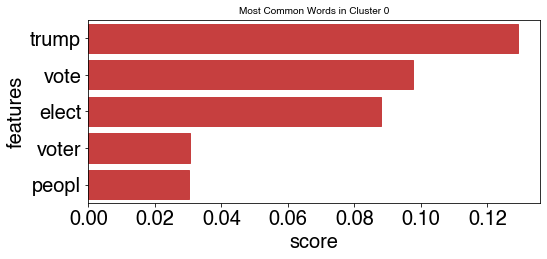

--------------
5372
['@magninano China with the aid of RNA vaccine producers, Harvard, Fauci, Collins, NIH, and quite a few others.'
 "@Truth_Abides There's a lot of dots to connect, but the story is there and it predates the release of covid-19. Its is something I have tried to convey since March, but has fallen on deaf ears. Another string of articles. https://t.co/tVpqQjLSlD"
 '@mattdeter @cletusyeetus1 @CowgirlWarrior @IvyShoots @murmalerm @bobx_akins Harvard didn’t write that nonsense, rape apologist'
 'Yes! @NicoleFleetwoo2 Nicole Fleetwood’s\xa0Marking Time: Art in the Age of Mass Incarceration\xa0(Harvard University Press, 2020) https://t.co/Reae0aQ8AL'
 'Woke up at 3 a.m. this morning to join Harvard Graduate School of Education webinar. https://t.co/8QJ9oiXhYP']


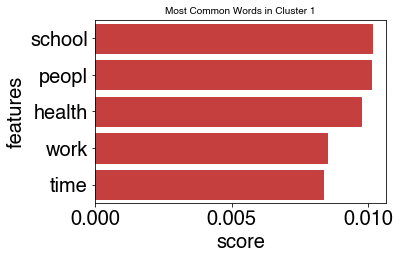

--------------
154
['Is Flying Safer Than Grocery Shopping? Harvard Study Says It Could Be https://t.co/a7g322onc8'
 'Harvard study: Flying has lower COVID-19 risk than grocery shopping | https://t.co/b9qz7s7SWE https://t.co/OvFPz0RZil'
 'Flying can be safer than grocery shopping, Harvard study asserts https://t.co/7qQOSpCxMs via @CNNTravel'
 'Harvard study: Flying has lower COVID-19 risk than grocery shopping or eating out https://t.co/gJxGrqkdo2 via @BostonDotCom'
 'Flying can be safer than grocery shopping, Harvard study asserts\nhttps://t.co/N3Rj3EM5eW']


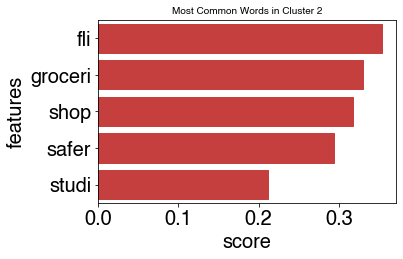

--------------
22
['Harvard doctor rips White House for listing ‘ending the COVID-19 pandemic’ as Trump accomplishment https://t.co/sSZkqkGgQ0 #covid19'
 '@realDonaldTrump read this, you murdering, amoral, narcissistic fascist cretan.\n\nhttps://t.co/Rir83qQG0q: Harvard doctor rips White House for listing ‘ending the COVID-19 pandemic’ as Trump accomplishment.\nhttps://t.co/qWvufcsEjs\n\nvia @GoogleNews'
 'Harvard doctor rips White House for listing ‘ending the COVID-19 pandemic’ as Trump accomplishment https://t.co/0F0o1YFmde via @BostonDotCom'
 'Harvard doctor rips White House for listing ‘ending the COVID-19 pandemic’ as Trump accomplishment https://t.co/Y3QsudZv8O #covid19'
 'Harvard doctor rips White House for listing ‘ending the COVID-19 pandemic’ as Trump accomplishment https://t.co/hgfYINqXuW via @BostonDotCom']


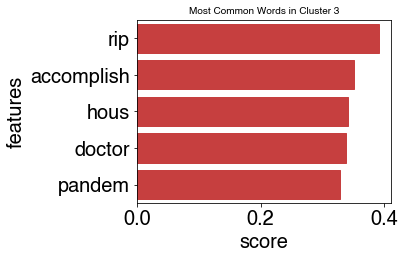

--------------
50
['Managers often write off employees as “difficult people,” but are your employees saying the same about you? https://t.co/dgwsQFDaHH'
 'Which Matters More: Hiring Superstars, or Removing Toxic Employees? Harvard Research Reveals the Surprising Answer .  #superstar employees are great but ditch first the #toxic member !! https://t.co/Z27sxeCkWE'
 'What impacts your bottom line more? Superstar employees, or toxic employees? The answer may surprise you. https://t.co/TaHyyaTZPR'
 'Which Matters More: Hiring Superstars, or Removing Toxic Employees? Harvard Research Reveals the Surprising Answer | https://t.co/Hw5NQQHnoF https://t.co/Jzy3A0YGzo'
 'Which Matters More: Hiring Superstars, or Removing Toxic Employees? Harvard Research Reveals the Surprising Answer https://t.co/OD4XAFXAgN']


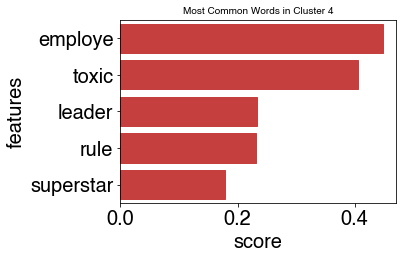

--------------
75
['Arizona Congressman Compares His Grueling Harvard Admission Story To Jared Kushner\'s https://t.co/vteZIm43wj via @Yahoo Jared  is the problem Rep.Gallego and AOC are the solution they work he has never "worked"a day in his worthless ,privileged LIFE!!!'
 "Arizona Congressman Compares His Grueling Harvard Admission Story To Jared Kushner's #SmartNews  https://t.co/zp1Nx8rWSH"
 "Arizona Congressman Compares His Grueling Harvard Admission Story To Jared Kushner's. Jared is a clueless, entitled, white privileged jerk. He has never known hardship of any https://t.co/J3gWA3Tqhz make these comments, he shows how out of touch he is.  https://t.co/W4iC2Hs7Mo"
 "Arizona Congressman Compares His Grueling Harvard Admission Story To Jared Kushner's https://t.co/e6A8XLkyIM via @Yahoo"
 "Arizona Congressman Compares His Grueling Harvard Admission Story To Jared Kushner's https://t.co/5vuRz5Cdrb via @Yahoo\n\nEvery time he opens his mouth bullshit falls out. Gang of white collar c

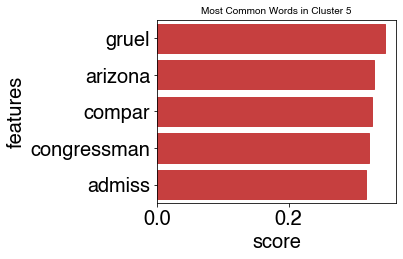

--------------
118
['@YPractitioners 1. Harvard 2. John Hopkins ....15. Yale! Hahaha'
 '@DataSciBae @red_abebe @black_in_ai Hope you get in! I just checked a few other programs, too:\n\nGRE is required: Yale, Dartmouth (home edition of GRE)...\nGRE is not required: Harvard, Princeton, Cornell, MIT, Johns Hopkins, Stanford (for PhD), Columbia...'
 '@black_in_ai \nI was asked: Is the GRE required to apply to grad programs in computer science this year? Depends on the school:\n\nIs required: Yale, Dartmouth (home edition of GRE)...\nIs not required: Harvard, Princeton, Cornell, MIT, Johns Hopkins, Stanford (for PhD), Columbia...'
 '@J__CROWN @Berkeley_EECS @black_in_ai @Cal_Engineer @BerkeleyDataSci I checked a few other computer science programs, too:\n\nIs required: Yale, Dartmouth (home edition of GRE)...\nIs not required: Harvard, Princeton, Cornell, MIT, Johns Hopkins, Stanford (for PhD), Columbia...'
 '@themaninbpt We have it. Yasir Qadhi is a Salafi preacher from Houston inciting v

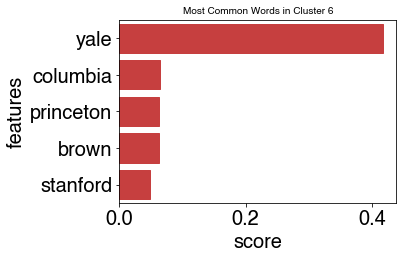

--------------
241
['30 minutes of Pure gold: A Step by Step Guide to Revenue Growth with Mark Roberge, Harvard Business School #Revenue #SaaS #Business #Sales #Marketing @markroberge @HarvardBiz https://t.co/y54zwYQnLE'
 'Don’t focus on #DigitalTransformation?! Yep, we said it. And we mean it—in a way. @Slalom tackles how to avoid getting stuck on your #cloud journey in an article on Harvard Business Review. @AWSCloud #HBR https://t.co/XT6YqC8Q3g'
 'According to Harvard Business Review (HBR), 99% of surveyed working adults in the US report having worked with at least one person who lacks social and self-awareness. While 73% of respondents indicate it was a coworker, 32% report it was their  https://t.co/Gl1w6MHsoa https://t.co/jIj2aOdIMm'
 'Harvard Business School Professor Jeff Bussgang On The Future Of Education\n\nhttps://t.co/ev1bnXWJ8G'
 'Remote work in governments: challenges and opportunities, with @tsedal (Harvard Business School) and Henna Khan (UK Civil Service HR). @Margari

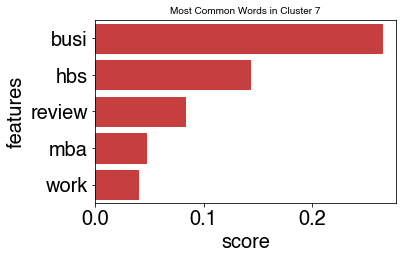

--------------
312
['I JUST GOT ACCEPTED INTO HARVARD LAW SCHOOL!?!'
 'And "Psychedelics Helped Me Reclaim My Life and Push to Change Drug Laws": https://t.co/CEHjXUiWNo'
 'Harvard Law School communist caucus is REALLY mad at Dad https://t.co/jVmCRuglXC'
 '"Strong &amp; autonomous #women\'s organizations are very important to pass laws + introduce policies" that tackle #GBV.\n\n— Professor @PeaceMedie of @BristolUni \n\n@wapppHKS @Harvard @Kennedy_School \n\n#gender #women #power #war #security https://t.co/Cscf9YEBri'
 '@garder17 @thedelitesite Dummy! She has an undergrad degree from Georgetown and a law degree from Harvard. What are your credentials?? She can make much more in the private sector and she will in four more years']


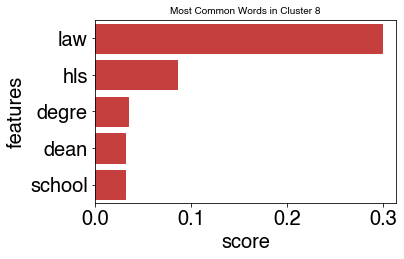

--------------
23
['Arizona congressman details his road to Harvard as a 1st-gen college student to make a statement https://t.co/kTzefGajUo via @Yahoo \n\nYAY!  Gallego'
 'Congressman goes viral detailing his road to Harvard as a 1st-gen college student.\nhttps://t.co/C1ga8PyCOO\n\nvia @GoogleNews'
 'Congressman goes viral detailing his road to Harvard as a 1st-gen college student  https://t.co/LJsFfBiHYz via @GMA'
 'Congressman goes viral detailing his road to Harvard as a 1st-gen college student Ask to see Kushners grades, very low even being bought paid for.. https://t.co/UR23L44ps7 via @GMA'
 'Congressman goes viral detailing his road to Harvard as a 1st-gen college student https://t.co/HzBQ6HWw2W https://t.co/ZyB7lHlZBS']


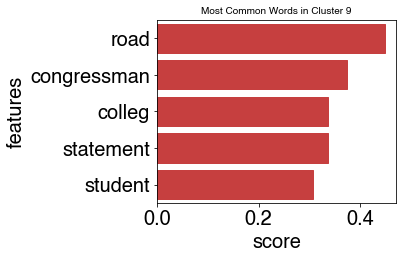

--------------
163
['@salmaaa98 I call Bennett Bennet Clark Kent Harvard'
 'I’m just saying I liked Bennett from the first night. Harvard? Bruh Claire wyd...'
 'Bennett is the Harvard JPJ so maybe Tayshia falls for Bennett! #TheBachelorette'
 'Bennett who, all I see is Harvard Clark Kent'
 'Hearing Harvard Bennet say that he lit Dale up lollll #TheBachelorette']


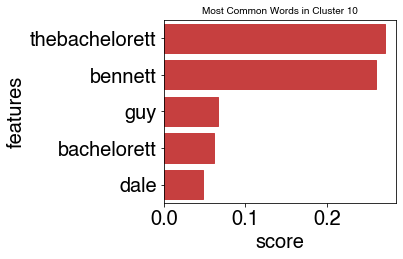

--------------
59
['.@kayleighmcenany Apparently you didn’t take the course on ethics @Harvard.'
 'Ethical concerns mount as AI takes bigger decision-making role #ICYMI https://t.co/82g5B7Lfbg'
 "⚙ @Harvard has joined @MIT in @enginexyz's $230m 2nd fund to invest in #toughtech.\n\n🚀 We share The Engine's commitment to tough tech - both @jwafs_mit and #TheEngine have backed @ViaSeparations, a startup making industrial separation cleaner and cheaper. https://t.co/psLBxYLqqU"
 'Harvard Joins MIT In Backing $250 Million Venture Fund Targeting Hard-Sell\xa0Startups https://t.co/7Qg3mrawQ2'
 'Help fund that eventual Harvard JD']


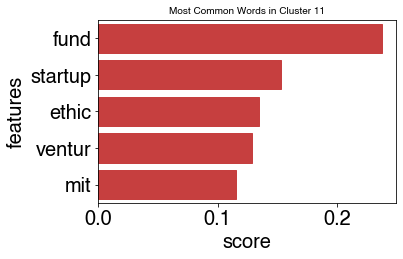

--------------
46
['#History \nOctober 29, 1921 - Centre College of Kentucky defeated Harvard University in what the New York Times called “arguably the upset of the century in college football.” https://t.co/y7BoRbdXMm'
 '1636: The Massachusetts Bay Colony votes to establish a theological college. It will later become Harvard University.\n\n1726: Jonathan Swift publishes "Gulliver\'s Travels."\n\n2/'
 '1636: The Massachusetts Bay Colony established the first college in the United States ~ today known as Harvard University https://t.co/tTOzkDgoAP'
 'Massachusetts is not real, like, I know Harvard is there but still'
 '@bellastuewe Can’t wait to get college started! Harvard ‘24']


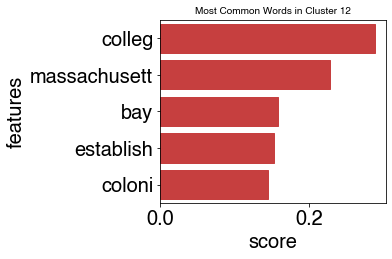

--------------
24
['This Harvard professor and his students have raised $14 million to make AI too smart to be fooled by hackers. Find out more. https://t.co/es7UPgnG2M https://t.co/qyFHPTduz0'
 'This Harvard professor and his students have raised $14 million to make AI too smart to be fooled by hackers. Find out more. https://t.co/TQQ0PXILP3'
 "@CryptoMind12 @analogsampler @knife_bear @BallerOfUSDT @TempeltownC @KingJimmyC @BriFitDance @CouchMeka @linker78330129 @AlexjFerraro @crypto_toro @CryptoMind12 you're a smart bregh you go to harvard or sme shyt!&gt;?!"
 'This Harvard professor and his students have raised $14 million to make AI too smart to be fooled by hackers. Find out more. https://t.co/f8A64pw7gs https://t.co/lQPMScmEkI'
 'This Harvard professor and his students have raised $14 million to make AI too smart to be fooled by hackers. Find out more. https://t.co/r7Bwpc7TrP https://t.co/VJEwZhj0Bp']


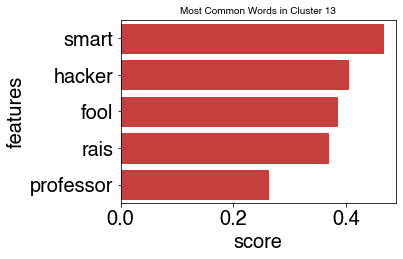

--------------
151
['@mattdeter @CowgirlWarrior @cletusyeetus1 @IvyShoots @murmalerm @bobx_akins Reardon didn’t graduate from Harvard lmfaoooo'
 '@nataliemarissol damn thas crazy i just copped a 10mil mansion and graduated from harvard'
 '@CowgirlWarrior @LourdesOvrAll @cletusyeetus1 @IvyShoots @murmalerm @bobx_akins Harvard isn’t fake. Neither was Pacific Western University, with three locations and many well known graduates, including Jin Tang, former executive of Microsoft China, and Bingu wa Murharika, the President of Malawi.'
 '@ieatjun here come the harvard graduates'
 '@WE_THE_BOYZ this fit kinda fire tho its like u are a harvard law graduate']


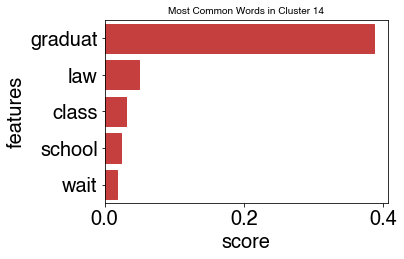

--------------
282
['Completed: The work is completed. https://t.co/C7c3IkEGgS'
 'The Center for Jewish Studies, Harvard University, is pleased to announce the 2021-2022 Daniel Jeremy Silver Fellowship. For more information and to apply, see https://t.co/sXw46v10EM. https://t.co/eHo244VMKm'
 "Could you increase your starting #salary at a new job by $5,000? That's exactly what happened in this study. https://t.co/HuJPpy1AVL"
 "1.53 Million Veterans Are Uninsured and 2 Million Can't Afford Care, New Harvard-Public Citizen Study Finds https://t.co/J82eoIYDKZ"
 'The Harvard Graduate School of Design announced it has restructured its Masters of Design Studies Program, raising concerns over how administrators came to the decision and whether the shift will dilute the degree’s educational value. https://t.co/megLMakLrj']


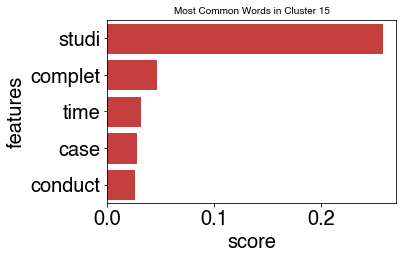

--------------
144
['Jared Kushner Asks Dad to Bribe His Way Into Electoral College \n\nNoting that Charles Kushner donated two and a half million dollars to Harvard before his son was accepted, Jared pointed out that his dad “might have to pony up more this time around.”\n\nhttps://t.co/xqEI3uKClg'
 'The Story Behind Jared Kushner’s Curious Acceptance Into Harvard — ProPublica https://t.co/qtA4qqUCIr'
 '@T_Cronin @GOPChairwoman Some more on Kushner\n\nhttps://t.co/pGvXcwznmV'
 '@Jewelz0107 @IvankaTrump Or how Jared got into Harvard\n\nhttps://t.co/pGvXcwznmV'
 "@GOPChairwoman Ronna Look into Jared's family - dad went to jail paid for Jared's entrance to Harvard \nSo corruption is right in front of you as well of all of the Trumps let is go\nhttps://t.co/pGvXcwznmV"]


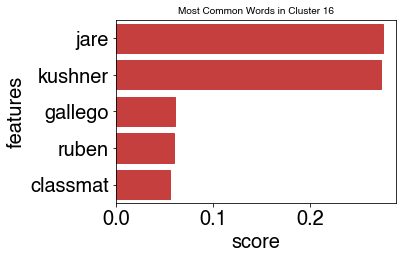

--------------
25
['The Mystery Of "The World’s Thinnest City" Harvard Researcher Says: "We Finally Know Why These Islanders Eat More Fatty Food Than Americans—Yet Stay Slim Well Into Their 90s... Now We Can Help Thousands Lose Weight Without Traditional Diets Or Exercise." https://t.co/IwVzau4TfQ'
 'The Mystery Of "The World’s Thinnest City" Harvard Researcher Says: "We Finally Know Why These Islanders Eat More Fatty Food Than Americans—Yet Stay Slim Well Into Their 90s... Now We Can Help Thousands Lose Weight Without Traditional Diets Or Exercise." https://t.co/eIWaNPP5it'
 'The Mystery Of "The World’s Thinnest City" Harvard Researcher Says: "We Finally Know Why These Islanders Eat More Fatty Food Than Americans—Yet Stay Slim Well Into Their 90s... Now We Can Help Thousands Lose Weight Without Traditional Diets Or Exercise." https://t.co/IXJn6q8bkq'
 'The Mystery Of "The World’s Thinnest City" Harvard Researcher Says: "We Finally Know Why These Islanders Eat More Fatty Food Than Amer

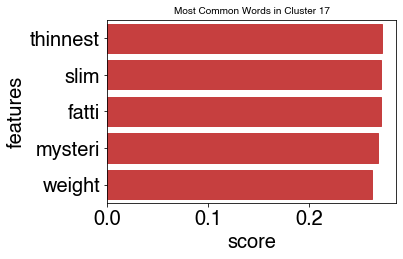

In [63]:
final_df_array = final_df.to_numpy()
prediction = orig_kmeans.labels_
n_feats = 5
dfs = get_top_features_cluster(final_df_array, prediction, n_feats)
plotWords(dfs, n_feats)


In [67]:
non_misc_cluster = list(range(18))
non_misc_cluster.remove(1)
kushner_cluster =   [5, 16, 9]
study_cluster =     [4, 2, 13, 17, 15]
school_cluster =    [7, 8]
trump_cluster =     [0, 3]
misc_misc_cluster = [6, 10, 11, 12, 14]

bachlorette_cluster = [10]
other_colleges_cluster = [6]
venture_cluster = [11]
grad_cluster = [14]
birthday_cluster = [12]
def calc_cluster_size(cluster_indices):
    sum = 0
    for i in cluster_indices:
        sum += cluster_sizes[i]
    return sum
print("Non-misc Cluster:", calc_cluster_size(non_misc_cluster))
print("Kushner Cluster:", calc_cluster_size(kushner_cluster))
print("Study Cluster:", calc_cluster_size(study_cluster))
print("Trump Cluster:", calc_cluster_size(trump_cluster))
print("School Cluster:", calc_cluster_size(school_cluster))
print("MM Cluster:", calc_cluster_size(misc_misc_cluster))

## misc misc cluster stuff
print("MM Cluster:", calc_cluster_size(misc_misc_cluster))
print("Bachlorette", calc_cluster_size(bachlorette_cluster))
print("other colleges:", calc_cluster_size(other_colleges_cluster))
print("graduates:", calc_cluster_size(grad_cluster))
print("h birthday:", calc_cluster_size(birthday_cluster))

print("--------------")
print(cluster_sizes[1])
print(np.array(tweets)[labels == 14][0:20])

Non-misc Cluster: 2211
Kushner Cluster: 242
Study Cluster: 535
Trump Cluster: 344
School Cluster: 553
MM Cluster: 537
MM Cluster: 537
Bachlorette 163
other colleges: 118
graduates: 151
h birthday: 46
--------------
5372
['@mattdeter @CowgirlWarrior @cletusyeetus1 @IvyShoots @murmalerm @bobx_akins Reardon didn’t graduate from Harvard lmfaoooo'
 '@nataliemarissol damn thas crazy i just copped a 10mil mansion and graduated from harvard'
 '@CowgirlWarrior @LourdesOvrAll @cletusyeetus1 @IvyShoots @murmalerm @bobx_akins Harvard isn’t fake. Neither was Pacific Western University, with three locations and many well known graduates, including Jin Tang, former executive of Microsoft China, and Bingu wa Murharika, the President of Malawi.'
 '@ieatjun here come the harvard graduates'
 '@WE_THE_BOYZ this fit kinda fire tho its like u are a harvard law graduate'
 'Not me in LA meeting people that graduated from Harvard and UCLA and I’m still stuck living in Jacksonville 🤦🏻\u200d♀️'
 'here come the h

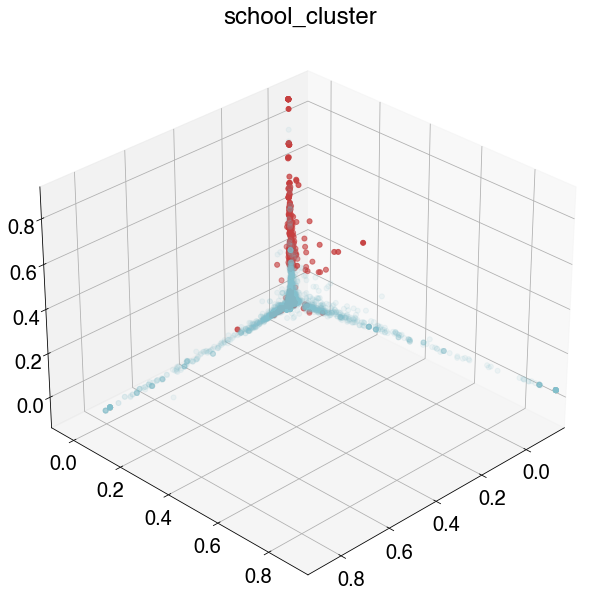

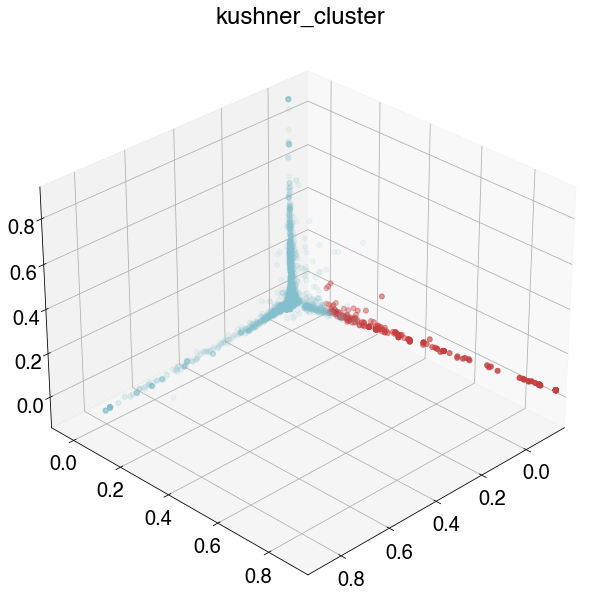

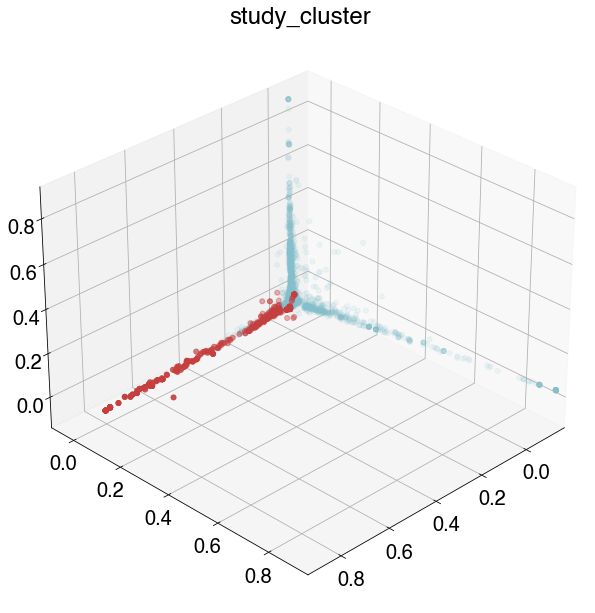

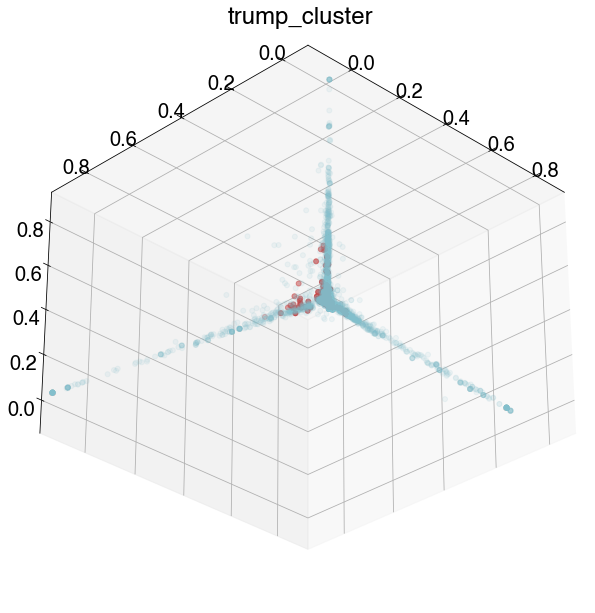

In [64]:
# kushner_cluster =   [5, 16, 9]
# study_cluster =     [4, 2, 13, 17, 15]
# school_cluster =    [7, 8]
# trump_cluster =     [0, 3]
# misc_misc_cluster = [6, 10, 11, 12, 14]

def plot_cluster(target_cluster, view_elev, view_azim, filename):
    indices = np.where(np.array(checkValid(labels, target_cluster)) == 1)
    neg_indices = np.where(np.array(checkValid(labels, target_cluster)) == 0)
    fig = plt.figure(figsize=(10, 8))
    ax = Axes3D(fig)
    ax.scatter(Y_sklearn[:, 0][neg_indices], Y_sklearn[:, 1][neg_indices], Y_sklearn[:, 2][neg_indices], s=25,
               color=primary_colors[1], alpha=0.1)
    ax.scatter(Y_sklearn[:, 0][indices], Y_sklearn[:, 1][indices], Y_sklearn[:, 2][indices], s=25, color=primary_colors[2])
    ax.view_init(elev = view_elev, azim = view_azim)
    ax.margins(x=-0.4, y=-0.4)
    plt.title(filename)
    plt.savefig(f'img-final/pcaclusters/{filename}.png')
    plt.show()

plot_cluster(school_cluster, 30, 45, "school_cluster")
plot_cluster(kushner_cluster, 30, 45, "kushner_cluster")
plot_cluster(study_cluster, 30, 45, "study_cluster")
plot_cluster(trump_cluster, -30, 225, "trump_cluster")
# trump cluster elev: -30, azim: 225

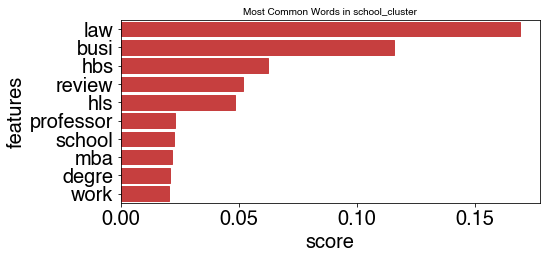

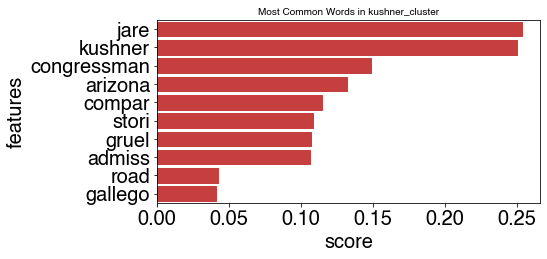

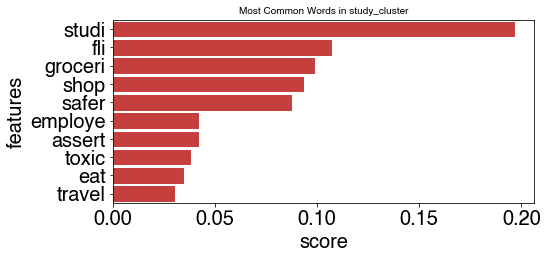

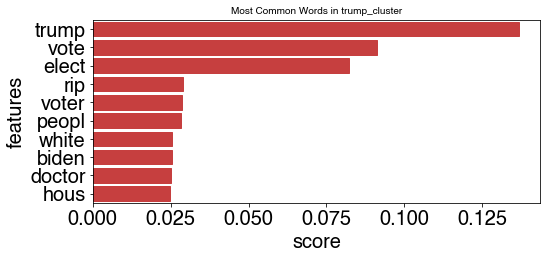

In [66]:
# tmp_df = get_top_feats_clusters(final_df_array, prediction, 10, school_cluster)
# plotClusterWords(tmp_df, 10, "school_cluster")

def drawClusterTopWords(target_cluster, filename):
    tmp_df = get_top_feats_clusters(final_df_array, prediction, 10, target_cluster)
    plotClusterWords(tmp_df, 10, filename)

drawClusterTopWords(school_cluster, "school_cluster")
drawClusterTopWords(kushner_cluster, "kushner_cluster")
drawClusterTopWords(study_cluster, "study_cluster")
drawClusterTopWords(trump_cluster, "trump_cluster")
